# 1.Instalar las librerias y sus versiones puestas en requirements.txt

#  2. Llamar las librerias necesarias para usar el API

In [1]:
# Packages
import pandas as pd # For saving the response data in CSV format
import os
import urllib.request, json, csv
import numpy as np
from tqdm import tqdm_notebook as tqdm
# For sending GET requests from the API
import requests
# For saving access tokens and for file management when creating and adding to the dataset
import os
# For dealing with json responses we receive from the API
import json
# For displaying the data after
import csv
# For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata
#To add wait time between requests
import time
import openpyxl


In [30]:
re = requests.get( "https://codeforces.com/api/contest.list?")

data_json = re.json()["result"]
data_json



# Convertir a DataFrame
df = pd.DataFrame(data_json )

# Filtrar por temporada que contenga "2019"
#filtered_df = df[df['season'].str.contains('2019')]

print(df.columns)


df['startTime'] = pd.to_datetime(df['startTimeSeconds'], unit='s')

df_sin_nat = df.dropna(subset=['startTime'])
# Opción 1: ambos timestamps con hora explícita
inicio_periodo = pd.Timestamp('2024-07-01 00:00:00')
fin_periodo = pd.Timestamp('2024-12-31 23:59:59')

# Creamos una máscara con condición que maneja NaT correctamente
condicion = (df['startTime'] >= inicio_periodo) & (df['startTime'] <= fin_periodo)

df_filtrado = df[condicion]

print(df_filtrado['startTime'].value_counts(ascending=False))


# Filtrar concursos cuyo nombre contenga "Hello", "Round", o "Good Bye"
condicion = df_filtrado['name'].str.contains('Hello|Round|Good Bye', case=False, na=False)

df_final = df_filtrado[condicion]

print(df_final.head)

Index(['id', 'name', 'type', 'phase', 'frozen', 'durationSeconds',
       'startTimeSeconds', 'relativeTimeSeconds', 'freezeDurationSeconds'],
      dtype='object')
2024-09-27 13:35:00    2
2024-10-20 09:05:00    2
2024-12-03 06:25:00    2
2024-08-30 14:35:00    2
2024-12-28 14:35:00    1
                      ..
2024-10-26 14:35:00    1
2024-10-24 14:35:00    1
2024-10-19 14:05:00    1
2024-10-14 14:35:00    1
2024-07-07 14:35:00    1
Name: startTime, Length: 61, dtype: int64
<bound method NDFrame.head of        id                                               name  type     phase  \
48   2053                        Good Bye 2024: 2025 is NEAR    CF  FINISHED   
49   2043  Educational Codeforces Round 173 (Rated for Di...  ICPC  FINISHED   
51   2051                      Codeforces Round 995 (Div. 3)  ICPC  FINISHED   
52   2049                      Codeforces Round 994 (Div. 2)    CF  FINISHED   
53   2048                         Codeforces Global Round 28    CF  FINISHED   
54   204

In [27]:
#Guardar el dataframe de los concursos. 
df_final.to_csv("listofcontests.csv", index=False)  # Set index=True if you want to keep the index column



In [34]:
def get_json_safe(url, max_retries=3, wait_time=2):
    """Intenta obtener un JSON válido de una API, con reintentos."""
    for attempt in range(max_retries):
        try:
            response = requests.get(url)
            time.sleep(wait_time)  # Evita ser bloqueado
            data = response.json()
            
            if data.get('status') == 'OK':
                return data
            else:
                print(f"❌ API error en {url} - status: {data.get('status')}")
                return None
                
        except Exception as e:
            print(f"⚠️ Error en intento {attempt + 1}/{max_retries} para {url}: {e}")
            time.sleep(wait_time)  # Esperar antes de reintentar
            
    print(f"❌ No se pudo obtener una respuesta válida después de {max_retries} intentos: {url}")
    return None


In [ ]:
# Recorremos todos los contestId del DataFrame
for contestId in df_final['id'].astype(str):
    print(f"🔄 Procesando contestId: {contestId}")
    
    # Crear carpeta para guardar resultados
    folder_path = f"contest_{contestId}"
    os.makedirs(folder_path, exist_ok=True)

    # ------------ API 1: contest.standings ------------
    url = f"https://codeforces.com/api/contest.standings?contestId={contestId}&asManager=False&showUnofficial=false"
    response = requests.get(url)
    
    data_json = get_json_safe(url)
    datacontest = data_json['result']
    df_contest = pd.json_normalize(datacontest['contest'])
    df_problems = pd.json_normalize(datacontest['problems'])
    problems_info = df_contest.merge(df_problems, how='cross')
    problems_info.to_csv(f"{folder_path}/problems_info.csv", index=False)

    # ------------ API 2: user.ratedList ------------
    url = f"https://codeforces.com/api/user.ratedList?activeOnly=False&includeRetired=False&contestId={contestId}"
    response = requests.get(url)
    
    data_json = get_json_safe(url)
    df_user_rated_list = pd.json_normalize(data_json['result'])
    df_user_rated_list.to_csv(f"{folder_path}/df_user_rated_list.csv", index=False)

    # ------------ API 3: contest.status ------------
    url = f"https://codeforces.com/api/contest.status?contestId={contestId}"
    response = requests.get(url)
    
    data_json = get_json_safe(url)
    df_user_contest_status = pd.json_normalize(data_json['result'])
    df_user_contest_status["handle"] = df_user_contest_status["author.members"].apply(lambda x: x[0]["handle"] if x else None)
    df_user_contest_status = df_user_contest_status.drop(columns=["author.members"])
    df_user_contest_status.to_csv(f"{folder_path}/df_user_contest_status.csv", index=False)

    # ------------ API 4: contest.ratingChanges ------------
    url = f"https://codeforces.com/api/contest.ratingChanges?contestId={contestId}"
    response = requests.get(url)
    
    data_json = get_json_safe(url)

    # Verificar si hay resultados
    if 'result' in data_json and len(data_json['result']) > 0:
        df_user_rate_change = pd.json_normalize(data_json['result'])
        df_user_rate_change.to_csv(f"{folder_path}/df_user_rate_change.csv", index=False)
        
        # JOIN: rate_change + contest_status
        df_merged = df_user_contest_status.merge(df_user_rate_change, on="handle", how="left")
    else:
        print(f"⚠️ No hay cambios de rating para contestId {contestId}")
        
        # Guardar archivo vacío para dejar evidencia 
        pd.DataFrame().to_csv(f"{folder_path}/df_user_rate_change.csv", index=False)
        
        # Si no hay rate changes, usamos df_user_contest_status tal como está
        df_merged = df_user_contest_status.copy()

    # ------------ JOIN: user_rated_list + merged ------------
    df_users_complete = df_user_rated_list.merge(df_merged, on="handle", how="right")

    # ------------ JOIN final con problems_info ------------
    problems_info = problems_info.rename(columns={'index': 'problem.index'})
    df_users_complete['problem.index'] = df_users_complete['problem.index'].astype(str)
    problems_info['problem.index'] = problems_info['problem.index'].astype(str)
    result_all = df_users_complete.merge(problems_info, on='problem.index', how='inner')

        # Guardar result_all
    result_all.to_csv(f"{folder_path}/result_all.csv", index=False)

    print(f"✅ Datos del contest {contestId} guardados en carpeta '{folder_path}'")

print("🎉 Todos los contests fueron procesados correctamente.")

🔄 Procesando contestId: 1998
✅ Datos del contest 1998 guardados en carpeta 'contest_1998'
🔄 Procesando contestId: 1999
✅ Datos del contest 1999 guardados en carpeta 'contest_1999'
🔄 Procesando contestId: 1993
✅ Datos del contest 1993 guardados en carpeta 'contest_1993'
🔄 Procesando contestId: 1997
✅ Datos del contest 1997 guardados en carpeta 'contest_1997'
🔄 Procesando contestId: 1991
✅ Datos del contest 1991 guardados en carpeta 'contest_1991'
🔄 Procesando contestId: 1996
✅ Datos del contest 1996 guardados en carpeta 'contest_1996'
🔄 Procesando contestId: 1995
✅ Datos del contest 1995 guardados en carpeta 'contest_1995'
🔄 Procesando contestId: 1990
✅ Datos del contest 1990 guardados en carpeta 'contest_1990'
🔄 Procesando contestId: 1994
✅ Datos del contest 1994 guardados en carpeta 'contest_1994'
🔄 Procesando contestId: 1988
✅ Datos del contest 1988 guardados en carpeta 'contest_1988'
🔄 Procesando contestId: 1992
✅ Datos del contest 1992 guardados en carpeta 'contest_1992'
🔄 Procesan

In [39]:
# Lista para guardar los dataframes individuales
all_results = []

# Iteramos por todas las carpetas que comienzan con "contest_"
for folder in os.listdir():
    if folder.startswith("contest_") and os.path.isdir(folder):
        file_path = os.path.join(folder, "result_all.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df['contestId'] = folder.split("_")[1]  # Agrega columna contestId al final
            all_results.append(df)
        else:
            print(f"⚠️ No se encontró result_all.csv en {folder}")

# Concatenar todos los DataFrames en uno solo
df_master = pd.concat(all_results, ignore_index=True)

# Guardar el resultado final
df_master.to_csv("result_all_combined.csv", index=False)

print("✅ Todos los result_all.csv fueron combinados en result_all_combined.csv")

C:\Users\HP\AppData\Local\Temp\ipykernel_16400\1103817493.py:9: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\HP\AppData\Local\Temp\ipykernel_16400\1103817493.py:9: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\HP\AppData\Local\Temp\ipykernel_16400\1103817493.py:9: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\HP\AppData\Local\Temp\ipykernel_16400\1103817493.py:9: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\HP\AppData\Local\Temp\ipykernel_16400\1103817493.py:9: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\HP\AppData\Local

✅ Todos los result_all.csv fueron combinados en result_all_combined.csv


In [ ]:
basededatosfinal_hw2 = pd.read_csv("result_all_combined.csv", encoding='utf-8')

C:\Users\HP\AppData\Local\Temp\ipykernel_29468\920325423.py:1: DtypeWarning: Columns (5,16,41,44,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  basededatosfinal_hw2 = pd.read_csv("result_all_combined.csv", encoding='utf-8')


# Este es el link de la base de datos
https://drive.google.com/file/d/1HWygJbIFK5RDEctCXOqSJ0tj-CZ6FbIX/view?usp=sharing


# Estructura de mi dataset

In [ ]:

#Esta es la estructura original de mi dataset
basededatosfinal_hw2 = pd.read_csv("result_all_combined.csv", encoding='utf-8')



print(basededatosfinal_hw2.shape)           # (rows, columns)
print(basededatosfinal_hw2.columns.tolist()) # list of all variable names
basededatosfinal_hw2.info()   

(10497068, 65)
['contribution', 'lastOnlineTimeSeconds', 'rating_x', 'friendOfCount', 'titlePhoto', 'rank_x', 'handle', 'maxRating', 'avatar', 'registrationTimeSeconds', 'maxRank', 'organization', 'country', 'city', 'lastName', 'firstName', 'email', 'vkId', 'id_x', 'contestId_x', 'creationTimeSeconds', 'relativeTimeSeconds_x', 'programmingLanguage', 'verdict', 'testset', 'passedTestCount', 'timeConsumedMillis', 'memoryConsumedBytes', 'problem.contestId', 'problem.index', 'problem.name', 'problem.type', 'problem.points', 'problem.rating', 'problem.tags', 'author.contestId', 'author.participantId', 'author.participantType', 'author.ghost', 'author.startTimeSeconds', 'author.teamId', 'author.teamName', 'author.room', 'contestId_y', 'contestName', 'rank_y', 'ratingUpdateTimeSeconds', 'oldRating', 'newRating', 'id_y', 'name_x', 'type_x', 'phase', 'frozen', 'durationSeconds', 'startTimeSeconds', 'relativeTimeSeconds_y', 'contestId', 'name_y', 'type_y', 'points', 'rating_y', 'tags', 'openId',

In [ ]:

missing_percent = basededatosfinal_hw2.isnull().mean().reset_index()
missing_percent.columns = ['basededatosfinal_hw2', 'Missing %']
missing_percent = missing_percent[missing_percent['Missing %'] > 0]
missing_percent = missing_percent.sort_values('Missing %', ascending=False)
print(missing_percent)


###La cantidad de missings es muy grande. Voy a quedarme con las columnas que me importan y trataré de limpiar la data

       basededatosfinal_hw2  Missing %
63                   openId   0.999996
17                     vkId   0.999328
41          author.teamName   0.999015
40            author.teamId   0.999015
64                     rank   0.989242
16                    email   0.970173
14                 lastName   0.816227
13                     city   0.803165
15                firstName   0.801326
11             organization   0.781129
42              author.room   0.772618
12                  country   0.747520
5                    rank_x   0.576907
9   registrationTimeSeconds   0.566149
2                  rating_x   0.566149
10                  maxRank   0.566149
4                titlePhoto   0.566149
3             friendOfCount   0.566149
1     lastOnlineTimeSeconds   0.566149
7                 maxRating   0.566149
8                    avatar   0.566149
0              contribution   0.566149
32           problem.points   0.499875
60                   points   0.499875
44              contestNa

In [8]:
columnas_deseadas = [
    'contribution', 'rating_x', 'handle', 'maxRating', 'registrationTimeSeconds',
    'maxRank', 'organization', 'country', 'city', 'vkId', 'contestId_x',
    'creationTimeSeconds', 'relativeTimeSeconds_x', 'programmingLanguage', 'verdict',
    'problem.index', 'problem.name', 'problem.type', 'problem.points', 'problem.rating',
    'author.startTimeSeconds', 'oldRating', 'newRating', 'maxRating', "startTimeSeconds"
]

base_filtrada2 = basededatosfinal_hw2[columnas_deseadas]



In [9]:
base_filtrada2 = base_filtrada2.dropna(subset=['handle'])

In [10]:
solved_df = base_filtrada2[base_filtrada2['verdict'] == 'OK'].copy()


In [11]:
# Sort submissions by user and time
solved_df = solved_df.sort_values(['handle', 'creationTimeSeconds'])

# finished_n: mark that the user solved problem n
solved_df['finished_n'] = 1

# n_language: language used for problem n
solved_df['n_language'] = solved_df['programmingLanguage']

# relative_time_n: time from contest start to submission
solved_df['relative_time_n'] = solved_df['creationTimeSeconds'] - solved_df['startTimeSeconds']

# time_to_answer_n: difference between current relative_time and previous
solved_df['time_to_answer_n'] = solved_df.groupby('handle')['relative_time_n'].diff()

# rating_n: difficulty of the problem
solved_df['rating_n'] = solved_df['problem.rating']


In [13]:
# contest_name
solved_df['contest_name'] = solved_df['problem.name']  # or df_contest['name'] if available

# contest_start_time
solved_df['contest_start_time'] = solved_df['startTimeSeconds']




In [16]:
# rating_achieved: sum of ratings for problems user solved
user_rating_achieved = solved_df.groupby('handle')['rating_n'].sum().reset_index(name='rating_achieved')
solved_df = solved_df.merge(user_rating_achieved, on='handle', how='left')


## Codeforces Dataset Variables

### 📚 General Submission Info

| Column Name | Description |
|-------------|-------------|
| `id` | Unique ID for each submission |
| `handle` | Username of the participant |
| `programmingLanguage` | Language used for the submission |
| `verdict` | Result of the submission (e.g., OK, WRONG_ANSWER) |
| `passedTestCount` | Number of tests passed |
| `timeConsumedMillis` | Time taken to run the solution (ms) |
| `memoryConsumedBytes` | Memory used by the submission |

### 🧑‍💻 User Rating Info

| Column Name | Description |
|-------------|-------------|
| `oldRating` | Rating before the contest |
| `newRating` | Rating after the contest |
| `rank` | Final rank in the contest |

### 🧩 Problem Info

| Column Name | Description |
|-------------|-------------|
| `problem.index` | Problem index (A, B, C...) |
| `name` | Problem name |
| `tags` | List of tags (dp, greedy, etc.) |
| `points` | Problem difficulty points (if available) |

### 🏆 Contest Info

| Column Name | Description |
|-------------|-------------|
| `contestId` | ID of the contest |
| `contest.name` | Title of the contest |
| `contest.type` | Contest type (ICPC, CF, etc.) |

In [20]:
# First, let's create a pivot table for each variable we want in wide format

# For finished_n (whether the user solved the problem)
finished_pivot = solved_df.pivot_table(
    index='handle',
    columns='problem.index',
    values='finished_n',
    aggfunc='first',
    fill_value=0
).add_prefix('finished_')

# For n_language (language used)
language_pivot = solved_df.pivot_table(
    index='handle',
    columns='problem.index',
    values='n_language',
    aggfunc='first'
).add_prefix('language_')

# For relative_time_n (time to solve)
time_pivot = solved_df.pivot_table(
    index='handle',
    columns='problem.index',
    values='relative_time_n',
    aggfunc='first'
).add_prefix('time_')

# For time_to_answer_n (time difference)
time_diff_pivot = solved_df.pivot_table(
    index='handle',
    columns='problem.index',
    values='time_to_answer_n',
    aggfunc='first'
).add_prefix('time_diff_')

# For rating_n (problem difficulty)
rating_pivot = solved_df.pivot_table(
    index='handle',
    columns='problem.index',
    values='rating_n',
    aggfunc='first'
).add_prefix('rating_')

# Now let's get the user metadata that doesn't need pivoting
user_metadata = solved_df.drop_duplicates('handle').set_index('handle')[
    ['rating_achieved', 'country', 'city', 'rating',  
     'contest_name', 'contest_start_time']
]

# Combine all the pivoted dataframes
wide_df = user_metadata.join([
    finished_pivot,
    language_pivot,
    time_pivot,
    time_diff_pivot,
    rating_pivot
], how='outer')

# Reset index to make handle a column again
wide_df = wide_df.reset_index()

# Display the result
print(wide_df.head())

         handle  rating_achieved country city  rating  \
0       -------            54900     NaN  NaN     NaN   
1       ------_             4800     NaN  NaN     NaN   
2  -----__-----            19900     NaN  NaN     NaN   
3       -----as              900     NaN  NaN     NaN   
4         ----1            26200     NaN  NaN  1670.0   

                contest_name  contest_start_time  finished_A  finished_B  \
0                Only Pluses          1720708500           1           1   
1                 A+B Again?          1722954900           1           0   
2  Maximize the Last Element          1722177300           1           1   
3         Split the Multiset          1721054100           1           0   
4                Only Pluses          1720708500           1           1   

   finished_B1  ...  rating_G  rating_G1  rating_G2  rating_G3  rating_H  \
0            0  ...       NaN        NaN        NaN        NaN       NaN   
1            0  ...       NaN        NaN        

https://drive.google.com/file/d/1VeLC_nJrRgCzUvRNHL2E3YJezILyRh8Z/view?usp=sharing    aquí esta la base pivotada guardada.   la original antes de pivotar si pesa muchas gbs. trataré de subirlo y actualizarlo. mi internet a veces se cuelga

In [28]:
wide_df.to_csv('contest_results_wide_format.csv', index=False)

# Vamos a comenzar a realizar los gráficos

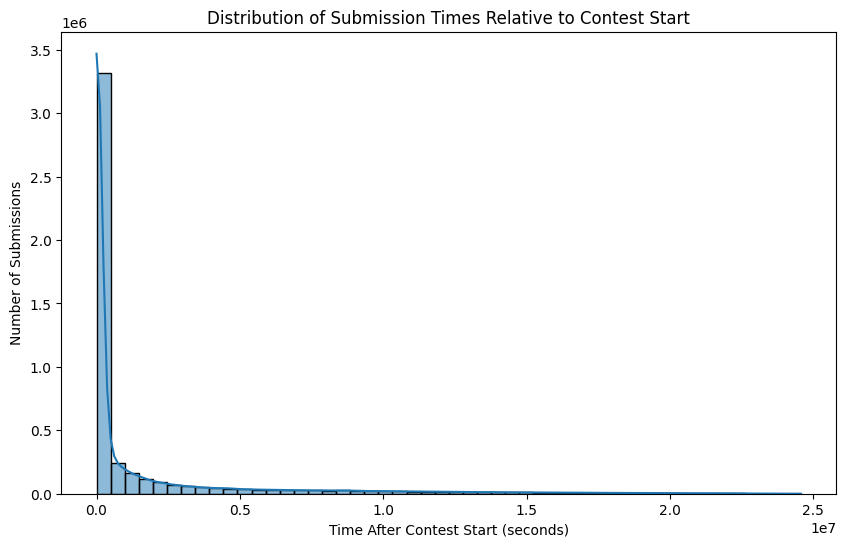

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=solved_df, x='relative_time_n', bins=50, kde=True)
plt.title('Distribution of Submission Times Relative to Contest Start')
plt.xlabel('Time After Contest Start (seconds)')
plt.ylabel('Number of Submissions')
plt.show()

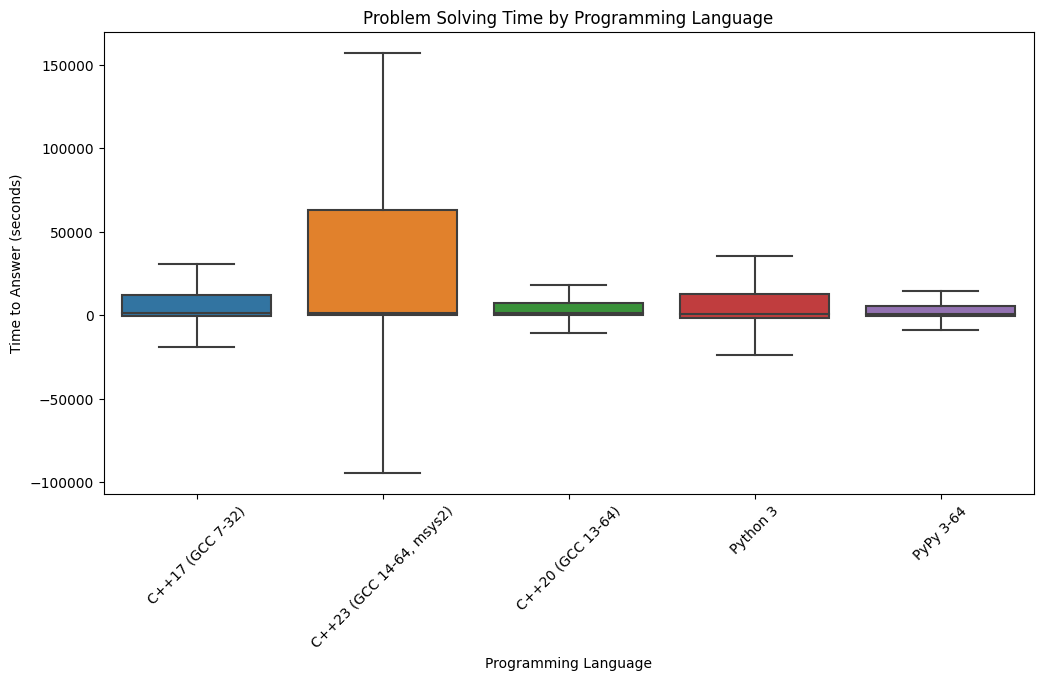

In [25]:
plt.figure(figsize=(12, 6))
top_languages = solved_df['n_language'].value_counts().nlargest(5).index
sns.boxplot(
    data=solved_df[solved_df['n_language'].isin(top_languages)],
    x='n_language',
    y='time_to_answer_n',
    showfliers=False  # Exclude outliers for readability
)
plt.title('Problem Solving Time by Programming Language')
plt.xlabel('Programming Language')
plt.ylabel('Time to Answer (seconds)')
plt.xticks(rotation=45)
plt.show()

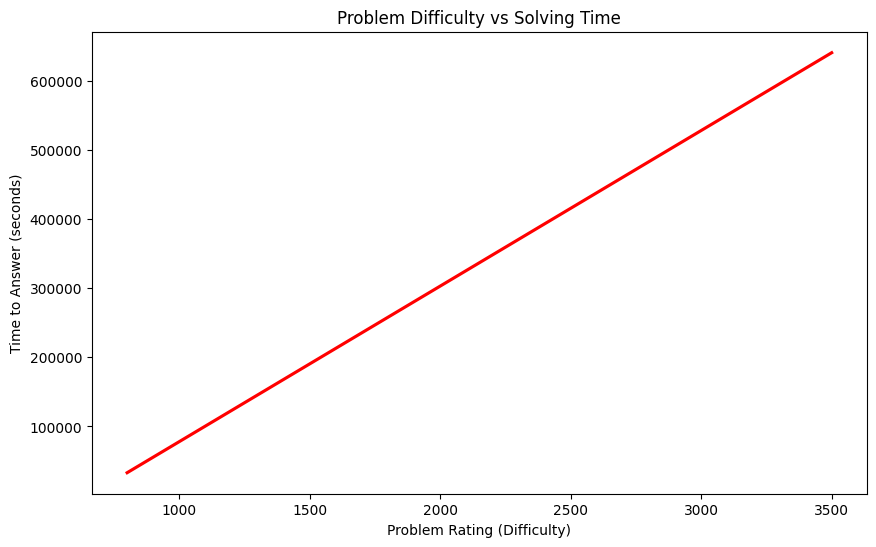

In [26]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=solved_df,
    x='rating_n',
    y='time_to_answer_n',
    scatter=False,
    ci=None,
    line_kws={'color':'red'},
    x_bins=20
)
plt.title('Problem Difficulty vs Solving Time')
plt.xlabel('Problem Rating (Difficulty)')
plt.ylabel('Time to Answer (seconds)')
plt.show()

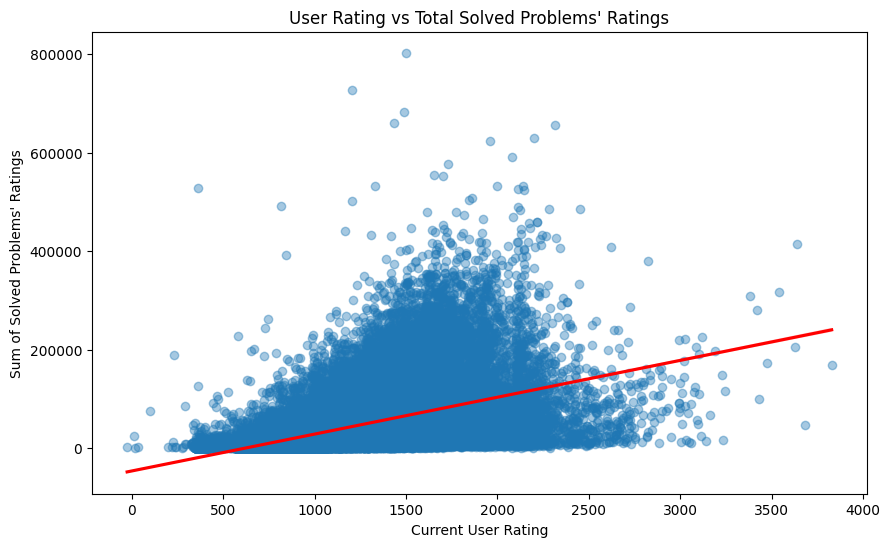

In [27]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=solved_df.drop_duplicates('handle'),
    x='rating',
    y='rating_achieved',
    scatter_kws={'alpha':0.4},
    line_kws={'color':'red'}
)
plt.title('User Rating vs Total Solved Problems\' Ratings')
plt.xlabel('Current User Rating')
plt.ylabel('Sum of Solved Problems\' Ratings')
plt.show()